# NLP Answers

- **Answer Set**: No. 05
- **Full Name**: Mohammad Hosein Nemati
- **Student Code**: `610300185`

---

## Introduction

In this problem, we are going to use **ParsBERT** pre-trained model for **Sequence Classification** task on **Persica** dataset.  
Then we will compare the reported metrics to previously trained models in `exercise 4`

In the first step, we will import some useful libraries.

In [25]:
import warnings

import math as math
import hazm as hazm

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=UserWarning)

---

## Loading

First of all, we must load the **Persica** dataset and then shuffle the records.

In [26]:
corpus = hazm.PersicaReader(csv_file="./drive/MyDrive/persica.csv")

data_frame = pd.DataFrame(corpus.docs())
data_frame = data_frame.sample(frac=1, random_state=313)
data_frame = data_frame.filter(["text", "category2"])

data_frame["length"] = data_frame["text"].apply(lambda text : len(hazm.word_tokenize(text)))

data_frame

,text,category2,length
879,به گزارش سرويس صنفي آموزشي خبرگزاري دانشجويان ...,آموزشي,552
5552,به گزارش ايسنا، در مطلبي كه در سايت موسسه سياس...,سياسي,460
1695,به گزارش خبرگزاري دانشجويان ايران (ايسنا)، دكت...,اجتماعي,252
4221,يك سرطان‌شناس و عضو هيات علمي دانشگاه اعلام كر...,بهداشتي,310
5553,در اين نمابر آمده است كه مسؤول انتظامات اين وا...,سياسي,968
...,...,...,...
10137,به گزارش خبرگزاري دانشجويان ايران (ايسنا)، اين...,ورزشي,273
6183,به گزارش خبرگزاري دانشجويان ايران (ايسنا)، روز...,سياسي,75
9175,معاون پشتيباني سازمان آموزش و پرورش خراسان رضو...,مذهبي,522
6570,سرپرست معاونت فني دبير خانه‌ي شوراي عالي اطلاع...,علمي,237


### Analyse

In this section, we are going to visualize the data and analyse and compute some useful parameters that will be used in the `Cleaning` and `Transformation` steps.

In [27]:
min_length = data_frame["length"].min()
max_length = data_frame["length"].max()

print(f"Minimum sentence length: {min_length}")
print(f"Maximum sentence length: {max_length}")

Minimum sentence length: 0
Maximum sentence length: 6686


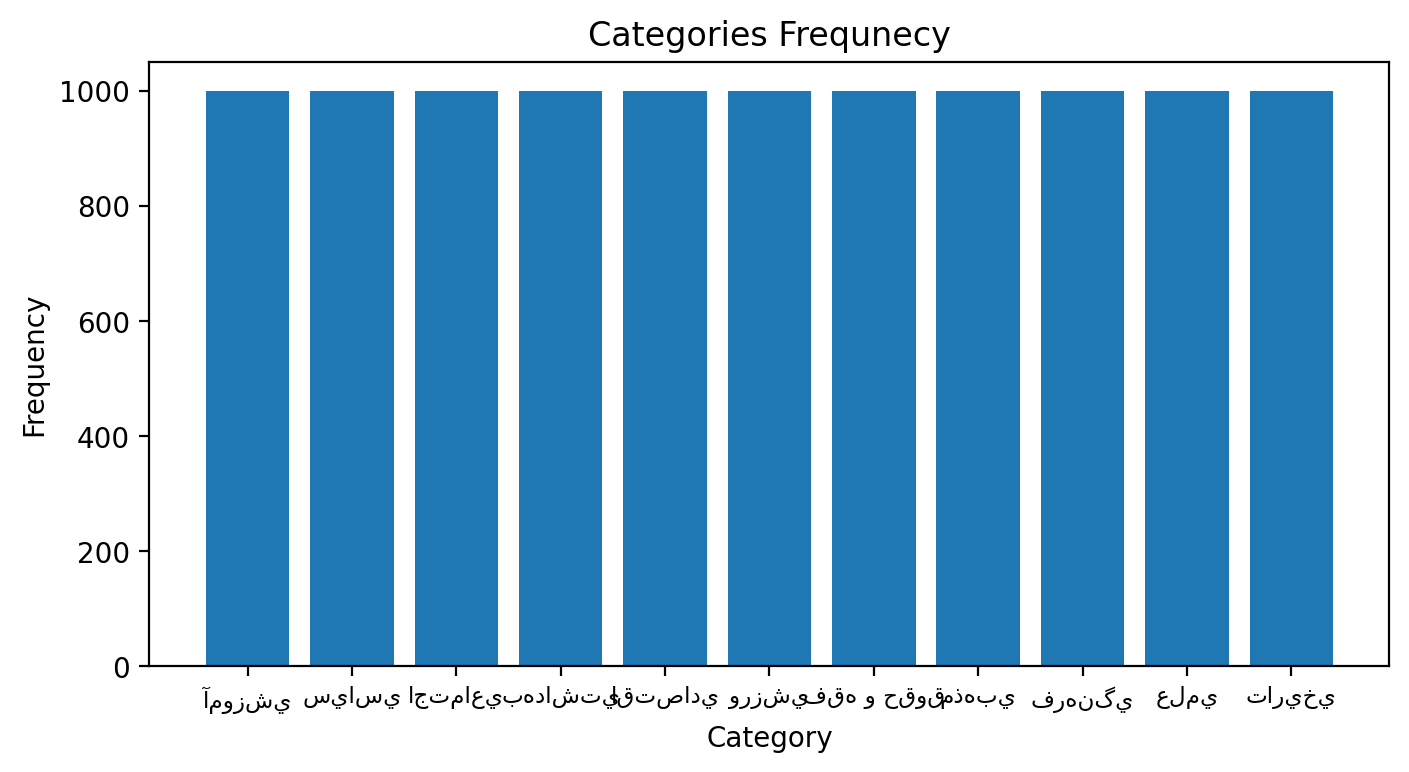

In [28]:
df = pd.Series(data_frame["category2"].value_counts())

plt.figure(figsize=(8, 4), dpi=200)
plt.bar(range(len(df)), df.values, align='center')
plt.xticks(range(len(df)), df.index.values, size='small')
plt.xlabel("Category")
plt.ylabel("Frequency")
plt.title("Categories Frequnecy")
plt.show()

---

## Preprocessing

In [29]:
stemmer = hazm.Stemmer()
normalizer = hazm.Normalizer()
lemmatizer = hazm.Lemmatizer()
stop_words = hazm.stopwords_list()

data_frame["text"] = data_frame["text"].apply(lambda text : " ".join([
    lemmatizer.lemmatize(normalizer.normalize(stemmer.stem(word)))
    for word in hazm.word_tokenize(text)
    if word not in stop_words
]))

In [30]:
labels = list(sorted(data_frame["category2"].unique()))

data_frame["label"] = data_frame["category2"].apply(lambda category: labels.index(category))

In [31]:
from datasets import Dataset
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased")

dataset = Dataset.from_pandas(data_frame).map(
    lambda x: tokenizer(x["text"], truncation=True, padding=True, max_length=512),
    batched=True
)

  0%|          | 0/11 [00:00<?, ?ba/s]

---

## Splitting

In [32]:
datasets = dataset.train_test_split(0.2)

train_set = datasets["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    batch_size=8,
)

test_set = datasets["test"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    batch_size=8,
)

---

## Training

In [33]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained("HooshvareLab/bert-fa-base-uncased", num_labels=len(labels))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
model.fit(train_set, epochs=4)

Epoch 1/4
1100/1100 [==============================] - 1132s 1s/step - loss: 0.7946 - accuracy: 0.7883
Epoch 2/4
1100/1100 [==============================] - 1127s 1s/step - loss: 0.2830 - accuracy: 0.9215
Epoch 3/4
1100/1100 [==============================] - 1127s 1s/step - loss: 0.1694 - accuracy: 0.9545
Epoch 4/4
1100/1100 [==============================] - 1126s 1s/step - loss: 0.1043 - accuracy: 0.9723


---

## Testing

In [35]:
result = model.evaluate(test_set)

print(result)

275/275 [==============================] - 100s 351ms/step - loss: 0.4431 - accuracy: 0.8918
[0.4431058466434479, 0.8918181657791138]


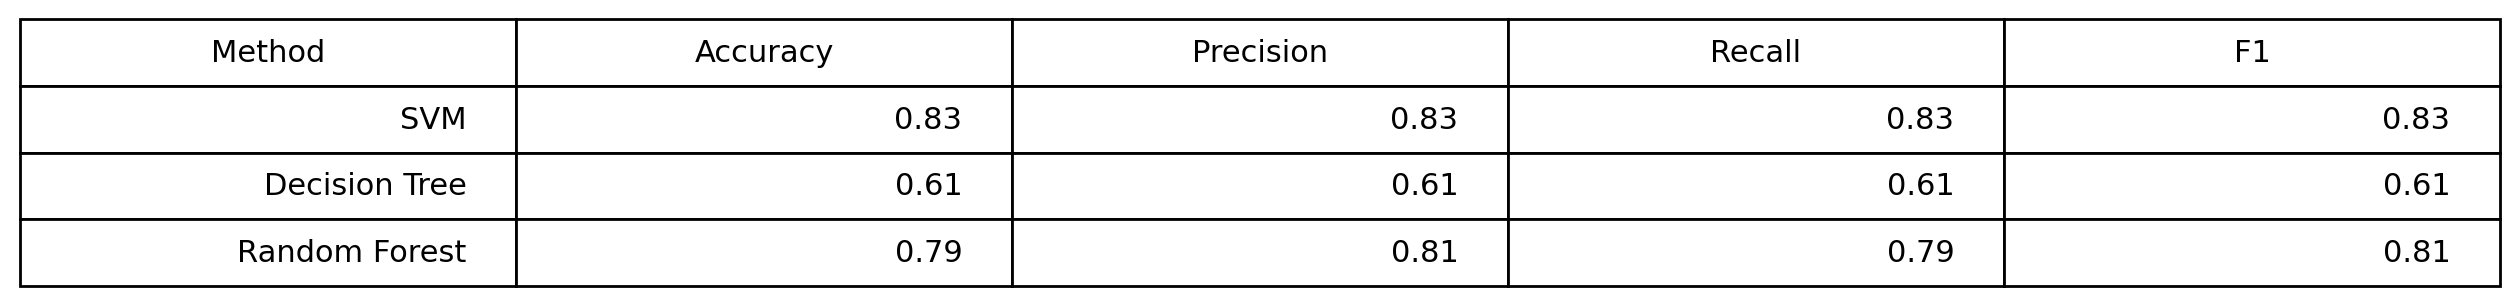

In [36]:
plt.figure(figsize=(8, 1), dpi=200)
table = plt.table(cellText=[
    [
        "SVM",
        "0.83",
        "0.83",
        "0.83",
        "0.83"
    ],
    [
        "Decision Tree",
        "0.61",
        "0.61",
        "0.61",
        "0.61",
    ],
    [
        "Random Forest",
        "0.79",
        "0.81",
        "0.79",
        "0.81",
    ],
], colLabels=["Method", "Accuracy", "Precision", "Recall", "F1"], loc="center")
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(2, 2)
plt.axis("off")
plt.show()

As we can see, the **Pars BERT** pre-trained model returend much better accuracy after fine-tuning.

---